In [3]:

import dataretrieval.nwis as nwis
import geopandas as gpd
from shapely.geometry import Point, box, Polygon, MultiPolygon
import requests
import pandas as pd
import datetime as dt
import earthaccess
from tqdm import tqdm
from shapely.ops import nearest_points
import sys
sys.path.append('modules/')
from retrieval_utils_appeearsTest import get_param_sites, get_scenes_results, get_scenes_temp, get_scenes_turb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import geopy
import ast
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


In [4]:
# import results, ensure spectra is list of dicts
param_codes = ['32316']
results = pd.read_csv(f"data/{param_codes[0]}_results.csv", dtype={'site_no': str})
results['spectra'] = results['spectra'].apply(ast.literal_eval)

# query the USGS database for temperature results, merge tables
temps = get_scenes_temp(results)
results['datetime'] = pd.to_datetime(results['datetime'], utc=True)
temps['datetime'] = pd.to_datetime(temps['datetime'], utc=True)
comb_results = pd.merge(results, temps, on=['site_no', 'datetime'], how='left')


Finding temperature for scenes: 100%|███████████| 93/93 [01:06<00:00,  1.40it/s]


In [5]:
# query the USGS database for turbidity results, merge tables
comb_results = comb_results.dropna(subset=['temp'])
turbs = get_scenes_turb(comb_results)
comb_results['datetime'] = pd.to_datetime(comb_results['datetime'], utc=True)
turbs['datetime'] = pd.to_datetime(turbs['datetime'], utc=True)
turb_results = pd.merge(comb_results, turbs, on=['site_no', 'datetime'], how='left')

Finding turbidity for scenes: 100%|█████████████| 92/92 [01:06<00:00,  1.38it/s]


In [10]:
#print(turb_results)

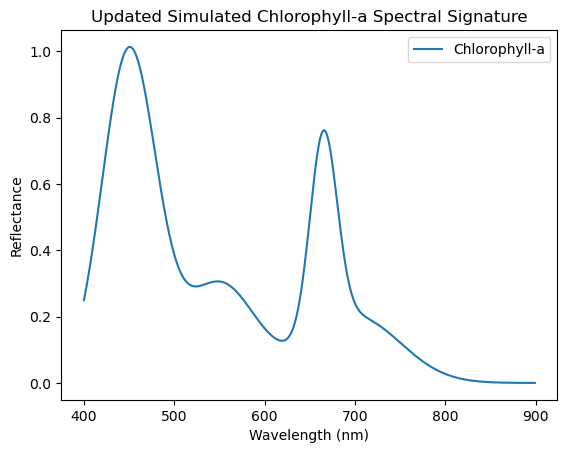

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated example: Wavelengths (nm)
wavelengths = np.arange(400, 900, 1)  # 400 to 900 nm range

# Adjust simulated reflectance for chlorophyll-a based on known absorption features
# Chlorophyll-a absorption in the blue (~430-450 nm) and red (~665 nm)
# High reflectance in green (~550 nm) and NIR (~700-750 nm)
chl_a_reflectance = (
    np.exp(-((wavelengths - 450) ** 2) / (2 * (30 ** 2))) +  # Blue absorption
    np.exp(-((wavelengths - 665) ** 2) / (2 * (15 ** 2))) * 0.6 +  # Red absorption (Qy band)
    np.exp(-((wavelengths - 550) ** 2) / (2 * (40 ** 2))) * 0.3 +  # Green reflectance
    np.exp(-((wavelengths - 700) ** 2) / (2 * (50 ** 2))) * 0.2    # NIR reflectance bump
)

# Plot the updated chlorophyll-a spectral signature
plt.plot(wavelengths, chl_a_reflectance, label='Chlorophyll-a')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Updated Simulated Chlorophyll-a Spectral Signature')
plt.legend()
plt.show()


In [16]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.linalg import norm
import pandas as pd

# Simulated example: Chlorophyll-a reference spectrum
wavelengths_ref = np.arange(400, 900, 1)  # Chlorophyll-a reference (400-900 nm)
chl_a_reflectance = np.exp(-((wavelengths_ref - 450) ** 2) / (2 * (30 ** 2))) + np.exp(-((wavelengths_ref - 680) ** 2) / (2 * (20 ** 2))) * 0.6

# Preprocess the spectral data in your dataset

# Function to filter and interpolate the spectra to match reference wavelengths (400-900 nm)
def preprocess_spectra(spectra, wavelengths_ref):
    # Extract wavelengths and reflectance from the spectra
    wavelengths = np.array([band['wavelength'] for band in spectra if band['reflectance'] != -9999.0])
    reflectance = np.array([band['reflectance'] for band in spectra if band['reflectance'] != -9999.0])
    
    # Check if we have any valid reflectance data
    if len(wavelengths) == 0 or len(reflectance) == 0:
        return np.full(len(wavelengths_ref), np.nan)  # Return NaN array if invalid
    
    # Interpolate reflectance to match the reference wavelengths
    f_interp = interp1d(wavelengths, reflectance, bounds_error=False, fill_value="extrapolate")
    reflectance_interp = f_interp(wavelengths_ref)

    # Normalize the interpolated reflectance (L2 normalization)
    reflectance_norm = reflectance_interp / norm(reflectance_interp)

    return reflectance_norm

# Apply preprocessing to the 'spectra' column in your dataset (for turbid water as an example)
turb_results['processed_spectra'] = turb_results['spectra'].apply(lambda x: preprocess_spectra(x, wavelengths_ref))

# Print the first few processed spectra for verification
print(turb_results['processed_spectra'].head())


0    [0.06207857760866028, 0.06313392550138655, 0.0...
1    [0.05164450465180512, 0.05203159627873196, 0.0...
2    [0.038416704562318965, 0.03919375335616573, 0....
3    [0.057023121695952736, 0.057737101378363166, 0...
4    [0.02787025674668492, 0.028308359713902196, 0....
Name: processed_spectra, dtype: object


           site_no  spectral_angle
0  441022122193200        0.790442
1         07380330        0.899982
2         07380330        0.993441
3         07380330        0.872545
4         07380330        1.030528


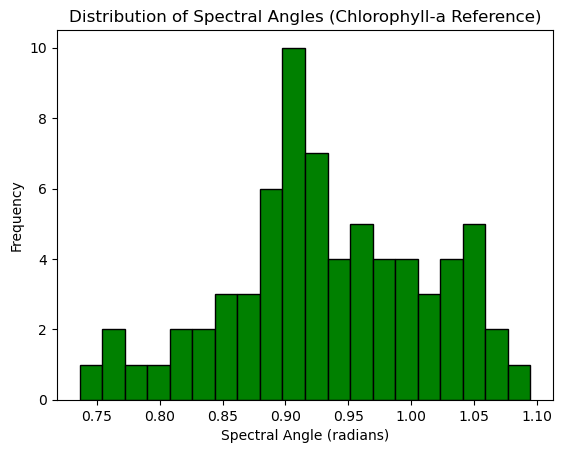

In [17]:
import numpy as np
import pandas as pd
from scipy.linalg import norm

# Simulated chlorophyll-a reference spectrum (from Step 2)
wavelengths_ref = np.arange(400, 900, 1)  # Chlorophyll-a reference (400-900 nm)
chl_a_reflectance = np.exp(-((wavelengths_ref - 450) ** 2) / (2 * (30 ** 2))) + np.exp(-((wavelengths_ref - 680) ** 2) / (2 * (20 ** 2))) * 0.6

# Function to calculate spectral angle between two spectra
def spectral_angle(spectrum1, spectrum2):
    # Normalize both spectra
    norm1 = norm(spectrum1)
    norm2 = norm(spectrum2)
    
    # Check for zero norms to avoid division by zero
    if norm1 == 0 or norm2 == 0:
        return np.nan
    
    # Compute the dot product and angle
    angle = np.arccos(np.clip(np.dot(spectrum1, spectrum2) / (norm1 * norm2), -1.0, 1.0))
    return angle

# Remove rows where 'processed_spectra' contains NaN values
turb_results_clean = turb_results.dropna(subset=['processed_spectra'])

# Apply spectral angle mapping (SAM) to each valid spectrum in the cleaned dataset
# Ensure there are no NaN values in the processed spectra
turb_results_clean['spectral_angle'] = turb_results_clean['processed_spectra'].apply(
    lambda x: spectral_angle(x, chl_a_reflectance) if not np.isnan(x).any() else np.nan
)

# Print the first few spectral angles for verification
print(turb_results_clean[['site_no', 'spectral_angle']].head())

# Optional: Filter out NaN values (i.e., where SAM calculation was not possible)
turb_results_clean = turb_results_clean.dropna(subset=['spectral_angle'])

# Optional: Visualize the distribution of spectral angles
import matplotlib.pyplot as plt
plt.hist(turb_results_clean['spectral_angle'], bins=20, color='green', edgecolor='black')
plt.xlabel('Spectral Angle (radians)')
plt.ylabel('Frequency')
plt.title('Distribution of Spectral Angles (Chlorophyll-a Reference)')
plt.show()


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
'''
# Plot 1: Spectral Angle vs Chlorophyll-a Concentration
plt.figure(figsize=(8, 6))
plt.scatter(turb_results_clean['spectral_angle'], turb_results_clean['result'].astype(float), 
            c='blue', edgecolor='k', s=100)
plt.xlabel('Spectral Angle (radians)')
plt.ylabel('Chlorophyll-a Concentration (ug/L)')
plt.title('Spectral Angle vs Chlorophyll-a Concentration')
plt.grid(True)
plt.show()

# Plot 2: Spectral Angle vs Turbidity
plt.figure(figsize=(8, 6))
plt.scatter(turb_results_clean['spectral_angle'], turb_results_clean['turbidity'].astype(float), 
            c='green', edgecolor='k', s=100)
plt.xlabel('Spectral Angle (radians)')
plt.ylabel('Turbidity (FNU)')
plt.title('Spectral Angle vs Turbidity')
plt.grid(True)
plt.show()

# Plot 3: Spectral Angle vs Temperature
plt.figure(figsize=(8, 6))
plt.scatter(turb_results_clean['spectral_angle'], turb_results_clean['temp'].astype(float), 
            c='red', edgecolor='k', s=100)
plt.xlabel('Spectral Angle (radians)')
plt.ylabel('Temperature (°C)')
plt.title('Spectral Angle vs Temperature')
plt.grid(True)
plt.show()
'''

"\n# Plot 1: Spectral Angle vs Chlorophyll-a Concentration\nplt.figure(figsize=(8, 6))\nplt.scatter(turb_results_clean['spectral_angle'], turb_results_clean['result'].astype(float), \n            c='blue', edgecolor='k', s=100)\nplt.xlabel('Spectral Angle (radians)')\nplt.ylabel('Chlorophyll-a Concentration (ug/L)')\nplt.title('Spectral Angle vs Chlorophyll-a Concentration')\nplt.grid(True)\nplt.show()\n\n# Plot 2: Spectral Angle vs Turbidity\nplt.figure(figsize=(8, 6))\nplt.scatter(turb_results_clean['spectral_angle'], turb_results_clean['turbidity'].astype(float), \n            c='green', edgecolor='k', s=100)\nplt.xlabel('Spectral Angle (radians)')\nplt.ylabel('Turbidity (FNU)')\nplt.title('Spectral Angle vs Turbidity')\nplt.grid(True)\nplt.show()\n\n# Plot 3: Spectral Angle vs Temperature\nplt.figure(figsize=(8, 6))\nplt.scatter(turb_results_clean['spectral_angle'], turb_results_clean['temp'].astype(float), \n            c='red', edgecolor='k', s=100)\nplt.xlabel('Spectral Angle (r

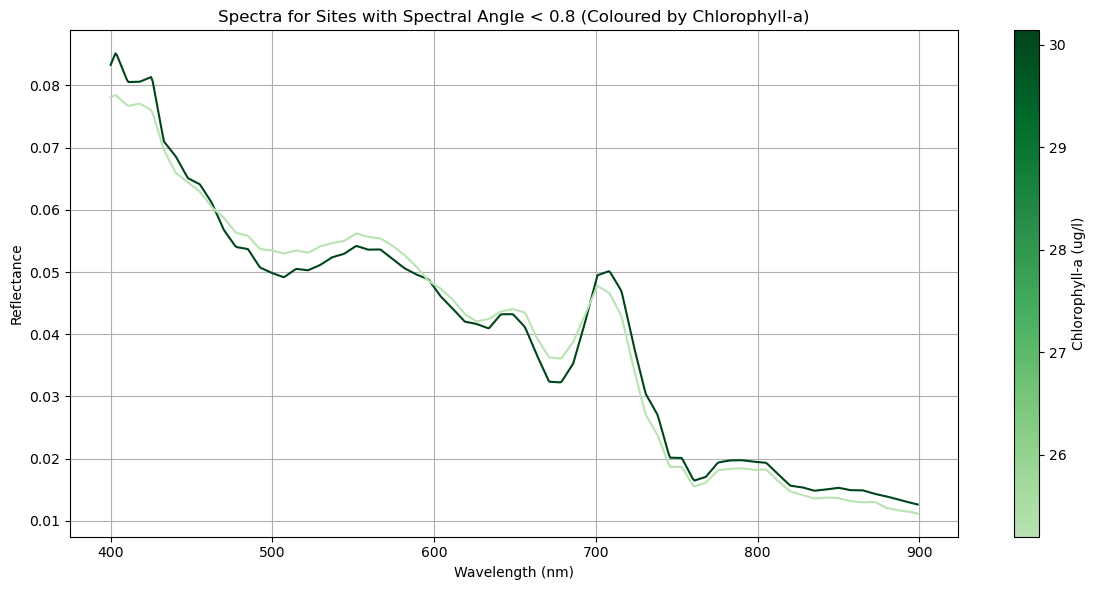

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Set a threshold for good spectral angles (e.g., < 0.8)
threshold = 0.76

turb_results_clean['rounded_spectral_angle'] = turb_results_clean['spectral_angle'].round(2)

# Filter the DataFrame for rows where spectral angle is less than the threshold
good_spectra_df = turb_results_clean[turb_results_clean['rounded_spectral_angle'] == threshold] 

# Normalize the chlorophyll-a (Chla) result values for color mapping
norm = mcolors.Normalize(vmin=good_spectra_df['result'].min(), vmax=good_spectra_df['result'].max())

# Adjust color map to avoid too much contrast between high and low values
cmap = cm.Greens
colors = cmap(np.linspace(0.3, 1, cmap.N))  # Start from 0.3 to avoid too faded colors
cmap_adjusted = mcolors.ListedColormap(colors)

# Plot the spectra for good sites and color the lines by Chla concentration
plt.figure(figsize=(12, 6))
for index, row in good_spectra_df.iterrows():
    # Get the color based on Chla result
    color = cmap_adjusted(norm(row['result']))
    
    # Plot the spectrum with color based on Chla
    plt.plot(wavelengths_ref, row['processed_spectra'], color=color)

# Add labels and color bar
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Spectra for Sites with Spectral Angle < 0.8 (Coloured by Chlorophyll-a)')

# Add color bar with adjusted color map
sm = cm.ScalarMappable(cmap=cmap_adjusted, norm=norm)
sm.set_array([])  # Dummy array for color bar
cbar = plt.colorbar(sm, ax=plt.gca(), label='Chlorophyll-a (ug/l)', orientation='vertical')  # Explicitly assign axis

plt.grid(True)
plt.tight_layout()
plt.show()
